# The Solow model with climate change

Imports and set magics:

In [20]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol, symbols, Eq, solve
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from tabulate import tabulate

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject
from modelproject import SolowModelClass 
model = SolowModelClass()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

Our model project is inspired by the exam in Macroeconomics I from the 9th of January 2020. The exam looks at the classic Solow model with technological growth and explores different levels of climate change, that cause damage to the production output with the fraction D. 

$$
\begin{aligned}
Y_t &= [1-D]K_t^\alpha (A_t L_t)^{1-\alpha}, 0 <\alpha<1\\
D &= 1-\frac{1}{1+\sigma{(\Delta T)}^2}, \sigma > 0 \\
K_{t+1} &= s Y_t+(1-\delta) K_t, 0<s<1,0<\delta<1,K_0>0 \\
A_{t+1} &=(1+g)A_t, A_0>0 \\
L_{t+1} &=(1+n)A_t, L_0>0
\end{aligned}
$$

The first equation is a Cobb-Douglas production function describing total output $(Y_t)$ as a function of physical capital $(K_t)$, population size $(L_t)$ and technology level $(A_t)$. We assume that climate change reduces output by share D; i.e. a part of output $(DY_t)$ is destroyed and only the share $1-D$ of output can be used for consumption and investment. The damage from climate change is given by the second equation, where $\Delta T$ measures change in temperature. Capital accumulation is described by the third equation, where $s$ is the saving rate and $\delta$ is the attrition rate. The last two equations indicate how the level of technology $(A_t)$ and the population $(L_t)$ evolve over time.

We define $\tilde y_t=\frac{Y_t}{A_tL_t}$ and $\tilde k_t = \frac{K_t}{A_tL_t}$.

## Analytical solution

We find the transition equation for capital per worker:

$$
\begin{aligned}
\frac{K_{t+1}}{A_{t+1} L_{t+1}} & =\frac{s Y_t+(1-\delta) K_t}{(1+g)(1+n) A_t L_t} \Leftrightarrow \\
\tilde{k}_{t+1} & =\frac{1}{(1+n)(1+g)}\left(s \tilde{y}_t+(1-\delta) \tilde{k}_t\right) \Leftrightarrow \\
\tilde{k}_{t+1} & =\frac{1}{(1+n)(1+g)}\left(s[1-D] \tilde{k}_t^\alpha+(1-\delta) \tilde{k}_t\right)
\end{aligned}
$$

In steady state $\tilde{k}_{t+1}=\tilde{k}_{t}=\tilde{k}^*$, which we use sympy to solve for. This is done in the py-file. We then find the steady state for capital to be: 

In [9]:
model.solve_analytical_ss()

((-delta - g*n - g - n)/(s*(D - 1)))**(1/(alpha - 1))

The transition equation can be shown in a phase diagram, where we see that the model converges to it's steady state value, irrespective of starting value.

We create a widget figure, where we vary the phase diagram for different values of the climate change damange D and time T. 

In [16]:
#We create a function for the phase diagram:
def phasediagram(d,T) :

    #We call for the model parameters 
    val = model.val

    #We create two listsm in which we will store the values of k_t+1 and the 45 degree line (diagonal). 
    kt1_list = []
    diagonal_list = []

    #We loop over the time T to find the different values of k_t+1 and append it to the list. 
    for t in range(0,T):
        k_t1 = (val.s*(1-d)*t**val.alpha+(1-val.delta)*t)/((1+val.n)*(1+val.g))
        kt1_list.append(k_t1)

    #We loop over the time T to create the 45 degree line
    for t in range(0,T):
        diagonal = t
        diagonal_list.append(diagonal)             
            
    #Steadystate
    #ss = model.solve_num_ss()

    #We create a plot with the two functions:
    plt.figure(figsize=(5,5))
    plt.plot(diagonal_list, kt1_list, label=r'$\tilde k_{t+1}$', color = 'red')
    plt.plot(diagonal_list, diagonal_list, label='45 degree line', color = 'black')
    #plt.scatter(model.D_vector.k_ss_list, model.D_vector.k_ss_list, c='g', linewidths=3, label='Steady State')
    #plt.text(ss, ss, '({}, {})'.format(round(ss,2), round(ss,2)))
    
    #We set limits and labels on the axis:
    plt.xlim(0,T)
    plt.ylim(0,T)
    plt.ylabel(r'$\tilde k_{t+1}$')
    plt.xlabel(r'$\tilde k_t$')
    
    #We set a title, grid and a legend
    plt.title('Figure 1: Phase diagram')
    plt.grid()
    plt.legend()
    return plt.show()

#We create a widget that slides through the values of D and T. 
widgets.interact(phasediagram, 
                        d     =  widgets.FloatSlider(description = 'D' , min = 0 ,    max = 1 , step = 0.1 , value = 0.0),
                        T     = widgets.IntSlider(description='Time' ,          min = 0,     max = 50, step = 1,    value = 10))


interactive(children=(FloatSlider(value=0.0, description='D', max=1.0), IntSlider(value=10, description='Time'…

<function __main__.phasediagram(d, T)>

Our phase diagram shows the intersection between $\tilde{k}_{t+1}$ and $\tilde{k}_{t}$ which is the steady state of capital in the model. The level of capital in the steady state decreases as we introduce climate change in the model, as it reduces the production. 

## Numerical solution

We solve the model numerically in our py-file, where we have defined the models parameter values as in the Macroeconomics I exam (question 2.4). This optimization is done with the root scalar optimizer.

We start by solving the model with D = 0 and there are thus no climate change in the model.

In [22]:
model.val.d = 0
model.solve_num_ss()

(7.1638190350558375, 1.915127622038289)

The steady state level of capital pr. capita in the model without climate change is $\tilde{k}^*=7.164$ and the steady state level of GDP pr. capita is $\tilde{y}^*=1.915$

We now want to solve the model nummerically when varing the amount of climate changes D. We print our results in a table to see the effects of climate change in different degrees 

In [25]:
#We refer to the definition in our py-file
model.D_vector()

╒═════╤══════════╤═══════════╤═══════════════════════════╕
│   D │     K_ss │      Y_ss │   Relative Y_ss compared  │
│     │          │           │       to situation where  │
│     │          │           │           D = 0 (in pct.) │
╞═════╪══════════╪═══════════╪═══════════════════════════╡
│ 0   │ 7.16382  │ 1.91513   │                 100       │
├─────┼──────────┼───────────┼───────────────────────────┤
│ 0.1 │ 6.12139  │ 1.63645   │                  85.4487  │
├─────┼──────────┼───────────┼───────────────────────────┤
│ 0.2 │ 5.13455  │ 1.37264   │                  71.6734  │
├─────┼──────────┼───────────┼───────────────────────────┤
│ 0.3 │ 4.20676  │ 1.12461   │                  58.7223  │
├─────┼──────────┼───────────┼───────────────────────────┤
│ 0.4 │ 3.34216  │ 0.89347   │                  46.6533  │
├─────┼──────────┼───────────┼───────────────────────────┤
│ 0.5 │ 2.54593  │ 0.680611  │                  35.5387  │
├─────┼──────────┼───────────┼──────────────────────────

It's clear to see, that for increasing climate change capital pr. capita and thus GDP pr. capita decreases 

# Further analysis

### Simulation

In the following, we wish to simulate evolution of relative output pr. capita for different scenarios of climate change and compare the levels of growth in output. 

We look at 3 scenarios:
- A situation without climate change $D = 0$
- A situation with sudden constant climate change $D = 0.175$ from period $t=1$
- A situation with increase climate change based on the damage function 


To make our simulation, we need to calculate the parameter value of $\sigma$. We use sympy to find an expression for $\sigma$ and then solve it with the parameter values $t=100$, $D_{100} = 0.175$, and $\Delta T_{year} = 0.04$, as it's assumed that the temperature increases $0.04^{\circ}C$ pr. year.

In [27]:
model.solve_sigma_expression()

-D/(dT**2*(D - 1))

In [12]:
model.solve_sigma()

sigma = 0.013258


We make our simulation 

In [13]:
#We run our 3 different simulations from the py-file: 
model = SolowModelClass()
sim = model.sim
model.simulate()
model.simulate2()
model.simulate3()

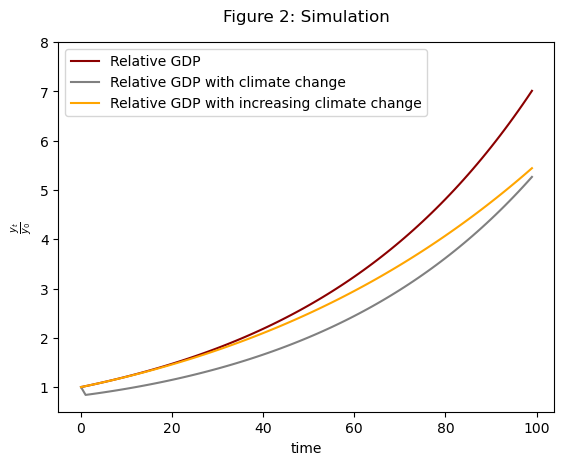

In [34]:
#We plot our simulations: 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(model.par.simT),sim.fracY,label='Relative GDP',c='darkred')
ax.plot(np.arange(model.par.simT),sim.fracYD,label='Relative GDP with climate change',c='grey')
ax.plot(np.arange(model.par.simT),sim.fracYDgrowth,label='Relative GDP with increasing climate change',c='orange')
plt.ylim([0.5,8]) 

#We set axis labels, title and legend
ax.set_xlabel('time')
ax.set_ylabel(r'$\frac{y_t}{y_0}$')
ax.set_title('Figure 2: Simulation',pad=15)
ax.legend();

Our simulation shows that climate change in any form affects the relative output pr. capita negatively. 
For the sudden temperature change the damages on output pr. capita are more substantial than if we impose slowly increasing temperatures, which is also the more realistic scenario. However, this scenario does show increasingly negative effects on the output growth.

### Extension of the model

# Conclusion